In [1]:
!7z x archive.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1257855648 bytes (1200 MiB)

Extracting archive: archive.zip
 69% 4096 Open              --
Path = archive.zip
Type = zip
Physical Size = 1257855648

  0%      1% 48 - chest_xray/test/NORMAL/NORMAL-2862975-0001.jpeg                                                           3% 106 - chest_xray/test/NORMAL/NORMAL-5200363-0001.jpeg                                                            4% 154 - chest_xray/test/NORMAL/NORMAL-6395296-0001.jpeg

In [ ]:
!nvidia-smi

Thu Sep 30 04:57:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [474]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dropout, Dense, Conv2D, MaxPooling2D, Flatten, InputLayer, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing import image

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

In [3]:
# Path for files in local notebook
train_dir = 'chest_xray/train'
test_dir = 'chest_xray/test'

# Base Model

In [421]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255 ,
                                                             validation_split=0.2 )

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [422]:
train_ds = train_gen.flow_from_directory(directory = train_dir,
                                         target_size=(150, 150), 
                                         class_mode = 'binary', 
                                         subset = 'training')

val_ds = train_gen.flow_from_directory(directory = train_dir,
                                       target_size=(150, 150), 
                                       class_mode = 'binary', 
                                       subset = 'validation')

test_ds = test_gen.flow_from_directory(directory = test_dir,
                                       target_size=(150, 150),
                                       class_mode = 'binary',
                                       shuffle=False)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [423]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dropout(.20))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)      

In [424]:
metrics_base = model.fit(train_ds,
                         epochs=30,  
                         validation_data=val_ds,
                         callbacks=[EarlyStopping( patience=5, verbose=1)]
                         )

Epoch 1/30
131/131 [==============================] - 49s 370ms/step - loss: 0.3426 - accuracy: 0.8541 - val_loss: 0.1192 - val_accuracy: 0.9598
Epoch 2/30
131/131 [==============================] - 48s 366ms/step - loss: 0.1533 - accuracy: 0.9379 - val_loss: 0.0889 - val_accuracy: 0.9703
Epoch 3/30
131/131 [==============================] - 48s 366ms/step - loss: 0.1206 - accuracy: 0.9501 - val_loss: 0.0784 - val_accuracy: 0.9722
Epoch 4/30
131/131 [==============================] - 48s 366ms/step - loss: 0.1217 - accuracy: 0.9522 - val_loss: 0.0828 - val_accuracy: 0.9684
Epoch 5/30
131/131 [==============================] - 48s 368ms/step - loss: 0.0926 - accuracy: 0.9637 - val_loss: 0.0677 - val_accuracy: 0.9722
Epoch 6/30
131/131 [==============================] - 48s 365ms/step - loss: 0.0810 - accuracy: 0.9692 - val_loss: 0.0740 - val_accuracy: 0.9742
Epoch 7/30
131/131 [==============================] - 48s 365ms/step - loss: 0.0792 - accuracy: 0.9706 - val_loss: 0.0712 - val_ac

In [425]:
metrics_val = model.evaluate(val_ds, verbose=0)
print('Val loss: ' + str(metrics_val[0]))
print('Val accuracy: ' + str(metrics_val[1]))

Val loss: 0.08646483719348907
Val accuracy: 0.9760765433311462


In [426]:
print(classification_report(test_ds.labels, (model.predict(test_ds) > 0.5).astype('int32')))

              precision    recall  f1-score   support

           0       0.98      0.72      0.83       234
           1       0.85      0.99      0.92       390

    accuracy                           0.89       624
   macro avg       0.92      0.85      0.87       624
weighted avg       0.90      0.89      0.88       624



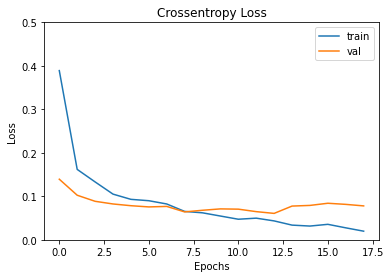

In [ ]:
plt.plot(metrics_base.epoch, metrics_base.history['loss'])
plt.plot(metrics_base.epoch, metrics_base.history['val_loss'])
plt.title('Crossentropy Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.ylim(0, 0.5)

plt.savefig(f'{image_dir}/Crossentropy Loss.png')

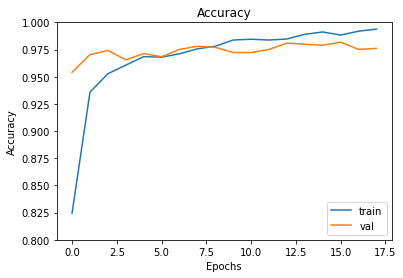

In [ ]:
plt.plot(metrics_base.epoch, metrics_base.history['accuracy'])
plt.plot(metrics_base.epoch, metrics_base.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])
plt.ylim(0.8, 1)

plt.savefig(f'{image_dir}/Accuracy.png')

Let's try transfer learning, and see if we can improve the accuracy.

# Transfer learning - Model 1



Base model (MobileNetV2) + a Flatten layer + three Dense layers

In [23]:
train_gen_t = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255 ,
                                                             validation_split=0.2 )

test_gen_t = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [24]:
train_ds_t = train_gen_t.flow_from_directory(directory = train_dir ,
                                         target_size=(224, 224),
                                         seed=42, 
                                         class_mode = 'binary', 
                                         subset = 'training')

val_ds_t = train_gen_t.flow_from_directory(directory = train_dir,
                                       target_size=(224, 224),
                                       seed=42, 
                                       class_mode = 'binary', 
                                       subset = 'validation')

test_ds_t = test_gen_t.flow_from_directory(directory = test_dir,
                                       target_size=(224, 224),
                                       class_mode = 'binary',
                                       shuffle=False)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [25]:
# Setting up the base model without the top layer
base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model.output
x = Flatten()(x) 
x = Dense(100, activation='relu')(x) 
x = Dense(50, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x) 

# Define formal model object to train and compile it
model_t = Model(inputs=base_model.input, outputs=predictions)
model_t.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

9420800/9406464 [==============================] - 0s 0us/step


In [26]:
metrics_model_t = model_t.fit(
                              train_ds_t,
                              epochs=30,  
                              validation_data=val_ds_t, 
                              callbacks=[EarlyStopping(patience=5, verbose=1,
                                                       restore_best_weights=True),
                                         ReduceLROnPlateau(monitor='val_loss',
                                                           factor=0.1,
                                                           patience=3)]
                              )

Epoch 1/30
131/131 [==============================] - 53s 390ms/step - loss: 0.5335 - accuracy: 0.9262 - val_loss: 0.0878 - val_accuracy: 0.9809
Epoch 2/30
131/131 [==============================] - 50s 384ms/step - loss: 0.0463 - accuracy: 0.9857 - val_loss: 0.0766 - val_accuracy: 0.9751
Epoch 3/30
131/131 [==============================] - 50s 384ms/step - loss: 0.0289 - accuracy: 0.9895 - val_loss: 0.0591 - val_accuracy: 0.9789
Epoch 4/30
131/131 [==============================] - 50s 386ms/step - loss: 0.0059 - accuracy: 0.9981 - val_loss: 0.0739 - val_accuracy: 0.9818
Epoch 5/30
131/131 [==============================] - 50s 385ms/step - loss: 0.0050 - accuracy: 0.9990 - val_loss: 0.0658 - val_accuracy: 0.9837
Epoch 6/30
131/131 [==============================] - 50s 386ms/step - loss: 4.6812e-04 - accuracy: 1.0000 - val_loss: 0.0741 - val_accuracy: 0.9847
Epoch 7/30
131/131 [==============================] - 50s 384ms/step - loss: 1.8591e-04 - accuracy: 1.0000 - val_loss: 0.0721 

In [27]:
metrics_val = model_t.evaluate(val_ds_t, verbose=0)
print('Val loss: ' + str(metrics_val[0]))
print('Val accuracy: ' + str(metrics_val[1]))

Val loss: 0.05910681188106537
Val accuracy: 0.9789473414421082


In [419]:
print(classification_report(test_ds_t.labels, (model_t.predict(test_ds_t) > 0.5).astype('int32')))

              precision    recall  f1-score   support

           0       0.99      0.80      0.89       234
           1       0.89      0.99      0.94       390

    accuracy                           0.92       624
   macro avg       0.94      0.90      0.91       624
weighted avg       0.93      0.92      0.92       624



(0.0, 0.6)

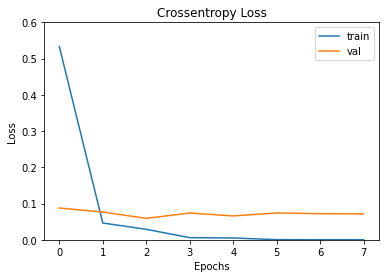

In [29]:
plt.plot(metrics_model_t.epoch, metrics_model_t.history['loss'])
plt.plot(metrics_model_t.epoch, metrics_model_t.history['val_loss'])
plt.title('Crossentropy Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.ylim(0, 0.6)

(0.7, 1.0)

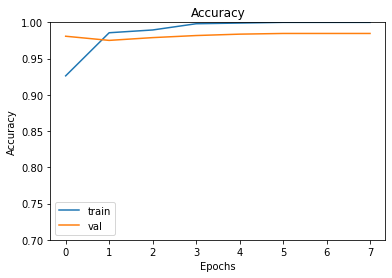

In [30]:
plt.plot(metrics_model_t.epoch, metrics_model_t.history['accuracy'])
plt.plot(metrics_model_t.epoch, metrics_model_t.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])
plt.ylim(0.7, 1)

# Transfer learning - Model 2

Base model + a Flatten layer + a Dense layer + a Dropout layer (0.5) + two Dense layers

In [33]:
base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 
for layer in base_model.layers:
    layer.trainable = False    

x_2 = base_model.output
x_2 = Flatten()(x_2) 
x_2 = Dense(100, activation='relu')(x_2) 
x_2 = Dropout(.5)(x_2)
x_2 = Dense(50, activation='relu')(x_2)
predictions_2 = Dense(1, activation='sigmoid')(x_2) 

model_t2 = Model(inputs=base_model.input, outputs=predictions_2)
model_t2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [34]:
metrics_model_t2 = model_t2.fit(
                              train_ds_t,
                              epochs=30,  
                              validation_data=val_ds_t, 
                              callbacks=[EarlyStopping(patience=5, verbose=1,
                                                       restore_best_weights=True),
                                         ReduceLROnPlateau(monitor='val_loss',
                                                           factor=0.1,
                                                           patience=3)]
                              )

Epoch 1/30
131/131 [==============================] - 53s 389ms/step - loss: 0.5597 - accuracy: 0.8935 - val_loss: 0.1434 - val_accuracy: 0.9665
Epoch 2/30
131/131 [==============================] - 50s 385ms/step - loss: 0.1746 - accuracy: 0.9405 - val_loss: 0.0903 - val_accuracy: 0.9713
Epoch 3/30
131/131 [==============================] - 51s 386ms/step - loss: 0.1371 - accuracy: 0.9546 - val_loss: 0.1294 - val_accuracy: 0.9646
Epoch 4/30
131/131 [==============================] - 50s 385ms/step - loss: 0.1409 - accuracy: 0.9489 - val_loss: 0.1193 - val_accuracy: 0.9713
Epoch 5/30
131/131 [==============================] - 50s 384ms/step - loss: 0.1166 - accuracy: 0.9584 - val_loss: 0.1472 - val_accuracy: 0.9627
Epoch 6/30
131/131 [==============================] - 51s 387ms/step - loss: 0.0991 - accuracy: 0.9611 - val_loss: 0.0759 - val_accuracy: 0.9818
Epoch 7/30
131/131 [==============================] - 50s 383ms/step - loss: 0.0768 - accuracy: 0.9740 - val_loss: 0.0656 - val_ac

In [35]:
metrics_val = model_t2.evaluate(val_ds_t, verbose=0)
print('Val loss: ' + str(metrics_val[0]))
print('Val accuracy: ' + str(metrics_val[1]))

Val loss: 0.06559360772371292
Val accuracy: 0.9818181991577148


In [420]:
print(classification_report(test_ds_t.labels, (model_t2.predict(test_ds_t) > 0.5).astype('int32')))

              precision    recall  f1-score   support

           0       1.00      0.73      0.84       234
           1       0.86      1.00      0.93       390

    accuracy                           0.90       624
   macro avg       0.93      0.87      0.88       624
weighted avg       0.91      0.90      0.89       624



(0.0, 0.6)

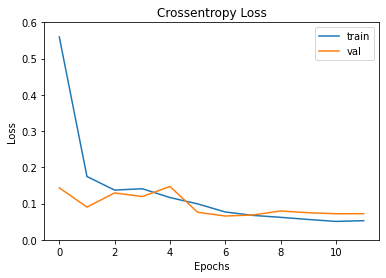

In [37]:
plt.plot(metrics_model_t2.epoch, metrics_model_t2.history['loss'])
plt.plot(metrics_model_t2.epoch, metrics_model_t2.history['val_loss'])
plt.title('Crossentropy Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.ylim(0, 0.6)

(0.85, 1.0)

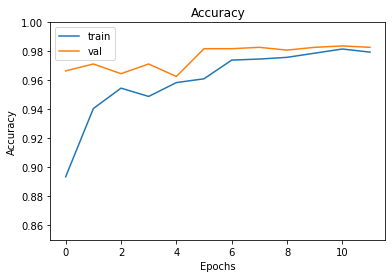

In [39]:
plt.plot(metrics_model_t2.epoch, metrics_model_t2.history['accuracy'])
plt.plot(metrics_model_t2.epoch, metrics_model_t2.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])
plt.ylim(0.85, 1)

# Transfer Learning - Model 3

Base model + a Flatten layer + a Dense layer + a Dropout layer (0.6) + two Dense layers

In [430]:
base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 
for layer in base_model.layers:
    layer.trainable = False    

x_3 = base_model.output
x_3 = Flatten()(x_3) 
x_3 = Dense(100, activation='relu')(x_3) 
x_3 = Dropout(.6)(x_3)
x_3 = Dense(50, activation='relu')(x_3)
predictions_3 = Dense(1, activation='sigmoid')(x_3) 

model_t3 = Model(inputs=base_model.input, outputs=predictions_3)
model_t3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [431]:
metrics_model_t3 = model_t3.fit(
                              train_ds_t,
                              epochs=30,  
                              validation_data=val_ds_t,
                              callbacks=[EarlyStopping(patience=5, verbose=1,
                                                       restore_best_weights=True),
                                         ReduceLROnPlateau(monitor='val_loss',
                                                           factor=0.1,
                                                           patience=3)]
                              )

Epoch 1/30
131/131 [==============================] - 53s 390ms/step - loss: 0.6119 - accuracy: 0.8875 - val_loss: 0.1024 - val_accuracy: 0.9589
Epoch 2/30
131/131 [==============================] - 51s 386ms/step - loss: 0.1816 - accuracy: 0.9267 - val_loss: 0.1266 - val_accuracy: 0.9388
Epoch 3/30
131/131 [==============================] - 51s 386ms/step - loss: 0.1496 - accuracy: 0.9422 - val_loss: 0.0848 - val_accuracy: 0.9742
Epoch 4/30
131/131 [==============================] - 50s 384ms/step - loss: 0.1435 - accuracy: 0.9556 - val_loss: 0.0892 - val_accuracy: 0.9751
Epoch 5/30
131/131 [==============================] - 50s 382ms/step - loss: 0.1228 - accuracy: 0.9580 - val_loss: 0.0776 - val_accuracy: 0.9770
Epoch 6/30
131/131 [==============================] - 51s 386ms/step - loss: 0.1486 - accuracy: 0.9463 - val_loss: 0.0678 - val_accuracy: 0.9780
Epoch 7/30
131/131 [==============================] - 51s 386ms/step - loss: 0.1089 - accuracy: 0.9491 - val_loss: 0.0814 - val_ac

In [432]:
metrics_val = model_t3.evaluate(val_ds_t, verbose=0)
print('Val loss: ' + str(metrics_val[0]))
print('Val accuracy: ' + str(metrics_val[1]))

Val loss: 0.06495990604162216
Val accuracy: 0.9770334959030151


In [433]:
print(classification_report(test_ds_t.labels, (model_t3.predict(test_ds_t) > 0.5).astype('int32')))

              precision    recall  f1-score   support

           0       0.99      0.79      0.88       234
           1       0.89      1.00      0.94       390

    accuracy                           0.92       624
   macro avg       0.94      0.89      0.91       624
weighted avg       0.93      0.92      0.92       624



In [434]:
metrics_test = model_t3.evaluate(test_ds_t, verbose=0)
print('Test loss: ' + str(metrics_test[0]))
print('Test accuracy: ' + str(metrics_test[1]))

Test loss: 0.2302469164133072
Test accuracy: 0.9182692170143127


# Transfer Learning - Model 4

Base layer + a Flatten layer + a Dense layer + a Dropout layer (0.2) + a Dense layer + a Dropout layer (0.2) + a Dense layer

In [437]:
base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 
for layer in base_model.layers:
    layer.trainable = False    

x_4 = base_model.output
x_4 = Flatten()(x_4) 
x_4 = Dense(100, activation='relu')(x_4) 
x_4 = Dropout(.2)(x_4)
x_4 = Dense(50, activation='relu')(x_4)
x_4 = Dropout(.2)(x_4)
predictions_4 = Dense(1, activation='sigmoid')(x_4) 

model_t4 = Model(inputs=base_model.input, outputs=predictions_4)
model_t4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [438]:
metrics_model_t4 = model_t4.fit(
                              train_ds_t,
                              epochs=30,  
                              validation_data=val_ds_t, 
                              callbacks=[EarlyStopping(patience=5, verbose=1,
                                                       restore_best_weights=True),
                                         ReduceLROnPlateau(monitor='val_loss',
                                                           factor=0.1,
                                                           patience=3)]
                              )

Epoch 1/30
131/131 [==============================] - 54s 394ms/step - loss: 0.6306 - accuracy: 0.8959 - val_loss: 0.1161 - val_accuracy: 0.9722
Epoch 2/30
131/131 [==============================] - 51s 385ms/step - loss: 0.1407 - accuracy: 0.9541 - val_loss: 0.0902 - val_accuracy: 0.9732
Epoch 3/30
131/131 [==============================] - 51s 387ms/step - loss: 0.0928 - accuracy: 0.9699 - val_loss: 0.1528 - val_accuracy: 0.9579
Epoch 4/30
131/131 [==============================] - 51s 389ms/step - loss: 0.0782 - accuracy: 0.9723 - val_loss: 0.0983 - val_accuracy: 0.9761
Epoch 5/30
131/131 [==============================] - 51s 390ms/step - loss: 0.0459 - accuracy: 0.9845 - val_loss: 0.0743 - val_accuracy: 0.9761
Epoch 6/30
131/131 [==============================] - 51s 388ms/step - loss: 0.0472 - accuracy: 0.9840 - val_loss: 0.0892 - val_accuracy: 0.9789
Epoch 7/30
131/131 [==============================] - 50s 386ms/step - loss: 0.0410 - accuracy: 0.9852 - val_loss: 0.1325 - val_ac

In [439]:
metrics_val = model_t4.evaluate(val_ds_t, verbose=0)
print('Val loss: ' + str(metrics_val[0]))
print('Val accuracy: ' + str(metrics_val[1]))

Val loss: 0.07417121529579163
Val accuracy: 0.9789473414421082


In [440]:
print(classification_report(test_ds_t.labels, (model_t4.predict(test_ds_t) > 0.5).astype('int32')))

              precision    recall  f1-score   support

           0       0.99      0.74      0.84       234
           1       0.86      0.99      0.92       390

    accuracy                           0.90       624
   macro avg       0.93      0.86      0.88       624
weighted avg       0.91      0.90      0.89       624



# Transfer Learning - Model 5 

Base model + a Flatten layer + a Dense layer + a Dropout layer (0.3) + two Dense layers

In [450]:
base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 
for layer in base_model.layers:
    layer.trainable = False    

x_5 = base_model.output
x_5 = Flatten()(x_5) 
x_5 = Dense(100, activation='relu')(x_5) 
x_5 = Dropout(.3)(x_5)
x_5 = Dense(50, activation='relu')(x_5)
predictions_5 = Dense(1, activation='sigmoid')(x_5) 

model_t5 = Model(inputs=base_model.input, outputs=predictions_5)
model_t5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [451]:
metrics_model_t5 = model_t5.fit(
                              train_ds_t,
                              epochs=30,  
                              validation_data=val_ds_t, 
                              callbacks=[EarlyStopping(patience=5, verbose=1,
                                                       restore_best_weights=True),
                                         ReduceLROnPlateau(monitor='val_loss',
                                                           factor=0.1,
                                                           patience=3)]
                              )

Epoch 1/30
131/131 [==============================] - 53s 392ms/step - loss: 0.6035 - accuracy: 0.9226 - val_loss: 0.1626 - val_accuracy: 0.9694
Epoch 2/30
131/131 [==============================] - 51s 386ms/step - loss: 0.1519 - accuracy: 0.9623 - val_loss: 0.1055 - val_accuracy: 0.9617
Epoch 3/30
131/131 [==============================] - 51s 387ms/step - loss: 0.0876 - accuracy: 0.9706 - val_loss: 0.0698 - val_accuracy: 0.9780
Epoch 4/30
131/131 [==============================] - 51s 386ms/step - loss: 0.0690 - accuracy: 0.9771 - val_loss: 0.0785 - val_accuracy: 0.9770
Epoch 5/30
131/131 [==============================] - 51s 388ms/step - loss: 0.0387 - accuracy: 0.9866 - val_loss: 0.0841 - val_accuracy: 0.9780
Epoch 6/30
131/131 [==============================] - 51s 387ms/step - loss: 0.0616 - accuracy: 0.9804 - val_loss: 0.1468 - val_accuracy: 0.9809
Epoch 7/30
131/131 [==============================] - 50s 385ms/step - loss: 0.0372 - accuracy: 0.9893 - val_loss: 0.1135 - val_ac

In [453]:
metrics_val = model_t5.evaluate(val_ds_t, verbose=0)
print('Val loss: ' + str(metrics_val[0]))
print('Val accuracy: ' + str(metrics_val[1]))

Val loss: 0.06984541565179825
Val accuracy: 0.977990448474884


In [454]:
print(classification_report(test_ds_t.labels, (model_t5.predict(test_ds_t) > 0.5).astype('int32')))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86       234
           1       0.87      1.00      0.93       390

    accuracy                           0.91       624
   macro avg       0.93      0.87      0.89       624
weighted avg       0.92      0.91      0.90       624



All five models provided about the same accuracy score (~0.98). Let's look at the recall score for all of them since recall is the most important metric here: it is more detrimental to have a patient who's infected with pneumonia to go home without further check up than asking a healthy patient to get more check ups. Calculate recall at the end of each model's own section.

After looking at the recall score for all of the models, model 2, model 3, and model 5 all have a recall of 1 (most likely rounded up by the classification report function).  I then compared precision score, and model 3 provides the best score of 0.89. Let's calculate the accuracy score for the test set for model 3 at its own section.

# Confusion Matrix





In [408]:
def make_confusion(test_label, y_pred):
  outcome_confusion = confusion_matrix(test_label, y_pred)
  plt.figure(dpi=100)
  sns.heatmap(outcome_confusion, cmap=plt.cm.Blues, annot=True, cbar=False,
  square=True, fmt='d',
  xticklabels=['Normal', 'Pneumonia'],
  yticklabels=['Normal', 'Pneumonia']);
  plt.title('Confusion Matrix')
  plt.xlabel('Prediction')
  plt.ylabel('Actual')

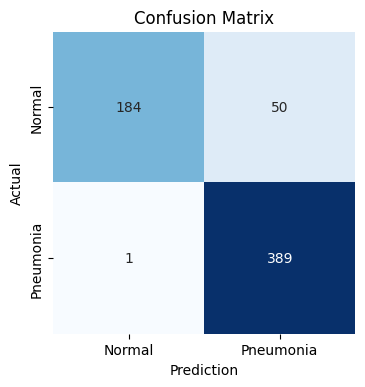

In [461]:
# Confusion matrix for transfer learning model 3
test_label_t3 = test_ds_t.labels
make_confusion(test_label_t3, (model_t3.predict(test_ds_t) > 0.5).astype('int32'))

# Putting prediction results and image together

In [462]:
pred = (model_t3.predict(test_ds_t) > 0.5).astype('int32')

file = [x for x in test_ds_t.filenames]
label = [y for y in test_ds_t.labels]
y_pred = [y[0] for y in pred]

df = pd.DataFrame(list(zip(file, label, y_pred)), columns = ['file', 'actual', 'prediction'])

In [463]:
def result(row):
  if (row.actual==0) & (row.prediction==0):
    return 'tn'
  if (row.actual==0) & (row.prediction==1):
    return 'fp'
  if (row.actual==1) & (row.prediction==0):
    return 'fn'
  if (row.actual==1) & (row.prediction==1):
    return 'tp'

In [464]:
df['result'] = df.apply (lambda row: result(row), axis=1)

In [465]:
df.head(10)

,file,actual,prediction,result
0,NORMAL/NORMAL-1049278-0001.jpeg,0,0,tn
1,NORMAL/NORMAL-1110860-0001.jpeg,0,0,tn
2,NORMAL/NORMAL-11419-0001.jpeg,0,0,tn
3,NORMAL/NORMAL-115218-0001.jpeg,0,0,tn
4,NORMAL/NORMAL-1160949-0001.jpeg,0,0,tn
5,NORMAL/NORMAL-1212407-0001.jpeg,0,0,tn
6,NORMAL/NORMAL-1228182-0001.jpeg,0,1,fp
7,NORMAL/NORMAL-1283091-0001.jpeg,0,1,fp
8,NORMAL/NORMAL-1318320-0001.jpeg,0,0,tn
9,NORMAL/NORMAL-1368583-0001.jpeg,0,0,tn


In [466]:
def get_img(file):
  img = image.load_img(file, target_size=(224,224))
  plt.imshow(img)

In [467]:
# Getting true negative observations
df[df.result == 'tn'].head()

,file,actual,prediction,result
0,NORMAL/NORMAL-1049278-0001.jpeg,0,0,tn
1,NORMAL/NORMAL-1110860-0001.jpeg,0,0,tn
2,NORMAL/NORMAL-11419-0001.jpeg,0,0,tn
3,NORMAL/NORMAL-115218-0001.jpeg,0,0,tn
4,NORMAL/NORMAL-1160949-0001.jpeg,0,0,tn


In [375]:
# Getting true negative images
tn_1 = 'chest_xray/test/NORMAL/NORMAL-1049278-0001.jpeg'
tn_2 = 'chest_xray/test/NORMAL/NORMAL-1110860-0001.jpeg'
tn_3 = 'chest_xray/test/NORMAL/NORMAL-11419-0001.jpeg'
tn_4 = 'chest_xray/test/NORMAL/NORMAL-115218-0001.jpeg'

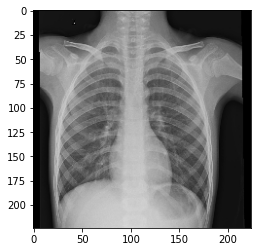

In [369]:
get_img(tn_1)

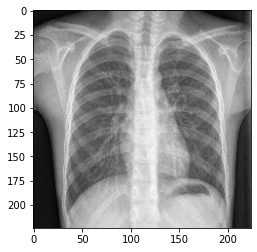

In [370]:
get_img(tn_2)

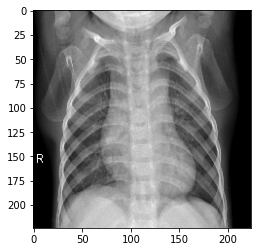

In [371]:
get_img(tn_3)

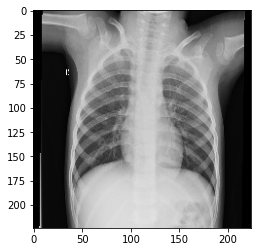

In [376]:
get_img(tn_4)

In [468]:
# Getting false positive obervations
df[df.result == 'fp'].head()

,file,actual,prediction,result
6,NORMAL/NORMAL-1228182-0001.jpeg,0,1,fp
7,NORMAL/NORMAL-1283091-0001.jpeg,0,1,fp
12,NORMAL/NORMAL-152130-0001.jpeg,0,1,fp
13,NORMAL/NORMAL-159472-0001.jpeg,0,1,fp
15,NORMAL/NORMAL-1627110-0001.jpeg,0,1,fp


In [377]:
# Getting false positive images
fp_1 = 'chest_xray/test/NORMAL/NORMAL-1228182-0001.jpeg'
fp_2 = 'chest_xray/test/NORMAL/NORMAL-1283091-0001.jpeg'
fp_3 = 'chest_xray/test/NORMAL/NORMAL-152130-0001.jpeg'
fp_4 = 'chest_xray/test/NORMAL/NORMAL-159472-0001.jpeg'

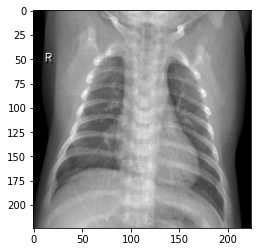

In [378]:
get_img(fp_1)

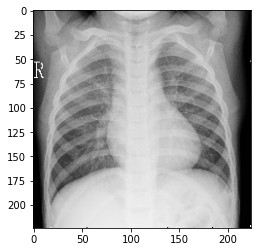

In [379]:
get_img(fp_2)

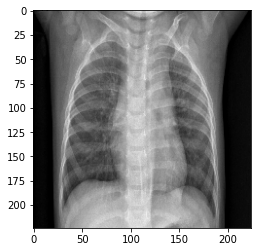

In [380]:
get_img(fp_3)

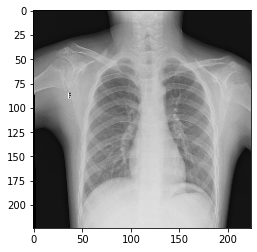

In [381]:
get_img(fp_4)

In [469]:
# Getting false negative obervations
df[df.result == 'fn'].head()

,file,actual,prediction,result
267,PNEUMONIA/BACTERIA-2131702-0001.jpeg,1,0,fn


In [382]:
# Getting the false negative image
fn_1 = 'chest_xray/test/PNEUMONIA/BACTERIA-2131702-0001.jpeg'

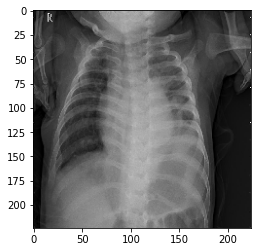

In [383]:
get_img(fn_1)

In [471]:
# Getting true positive observations
df[df.result == 'tp'].tail(10)

,file,actual,prediction,result
614,PNEUMONIA/VIRUS-9325276-0001.jpeg,1,1,tp
615,PNEUMONIA/VIRUS-9342284-0001.jpeg,1,1,tp
616,PNEUMONIA/VIRUS-9476607-0001.jpeg,1,1,tp
617,PNEUMONIA/VIRUS-9564688-0001.jpeg,1,1,tp
618,PNEUMONIA/VIRUS-9564688-0002.jpeg,1,1,tp
619,PNEUMONIA/VIRUS-9584831-0001.jpeg,1,1,tp
620,PNEUMONIA/VIRUS-9671740-0001.jpeg,1,1,tp
621,PNEUMONIA/VIRUS-9783315-0001.jpeg,1,1,tp
622,PNEUMONIA/VIRUS-9890836-0001.jpeg,1,1,tp
623,PNEUMONIA/VIRUS-9968655-0001.jpeg,1,1,tp


In [472]:
# Getting true positive images
tp_1 = 'chest_xray/test/PNEUMONIA/VIRUS-9890836-0001.jpeg'
tp_2 = 'chest_xray/test/PNEUMONIA/VIRUS-9671740-0001.jpeg'
tp_3 = 'chest_xray/test/PNEUMONIA/VIRUS-9783315-0001.jpeg'
tp_4 = 'chest_xray/test/PNEUMONIA/VIRUS-9968655-0001.jpeg'

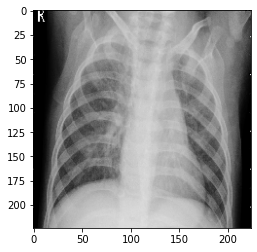

In [475]:
get_img(tp_1)

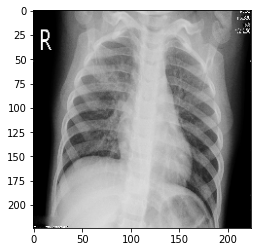

In [397]:
get_img(tp_2)

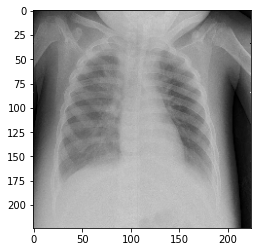

In [398]:
get_img(tp_3)

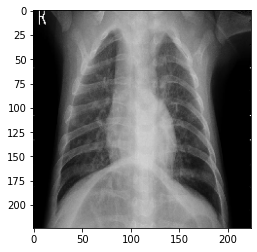

In [399]:
get_img(tp_4)